# Data Generators & Test Train Split

## Train and Test Split
To effectively train and evaluate our machine learning model, we need to split our dataset into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance on unseen data. We will use an 80-20 split, where 80% of the data is used for training and 20% for testing.

In [4]:
import os
import sys
import shutil
import numpy as np

Let's specify the path to our dataset and perform the split.

In [7]:
#Paths to the raw dataset
BASE_PATH = r'C:\Users\JTWit\Documents\ECE 579\Datasets\GTZAN Dataset'
IMAGES_PATH = os.path.join(BASE_PATH,"images_original")

#Path to where we will move the split data
SPLIT_BASE_PATH = r'C:\Users\JTWit\Documents\ECE 579\Datasets\Split GTZAN Dataset'
SPLIT_TRAIN_PATH = os.path.join(SPLIT_BASE_PATH, 'train')
SPLIT_TEST_PATH = os.path.join(SPLIT_BASE_PATH, 'test')


#Make the target base path and the train and text split directories
os.makedirs(SPLIT_BASE_PATH,exist_ok = True)
os.makedirs(SPLIT_TRAIN_PATH,exist_ok = True)
os.makedirs(SPLIT_TEST_PATH,exist_ok = True)

#Let's also include all the subfolders for train and test
for label in os.listdir(IMAGES_PATH):

    train_path = os.path.join(SPLIT_TRAIN_PATH,label)
    test_path = os.path.join(SPLIT_TEST_PATH,label)

    os.makedirs(train_path,exist_ok = True)
    os.makedirs(test_path,exist_ok = True)


Now that we have folders specified for the training and testing datasets, we can split the data accordingly.

First we will make a function that will get the paths of all images and their corresponding labels.

In [ ]:
images = {}
for root, dirs, files in os.walk(IMAGES_PATH):
    
    image_paths = []    
    for file in files:
        file_path = os.path.join(root,file)
        image_paths.append(file_path)

    key = file.split('0')[0]
    images[key] = image_paths


['C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00000.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00001.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00002.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00003.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00004.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00005.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00006.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00007.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_original\\rock\\rock00008.png', 'C:\\Users\\JTWit\\Documents\\ECE 579\\Datasets\\GTZAN Dataset\\images_o

Second, we will take the paths and split them into training and testing sets using an 80-20 ratio. We will use nummpy for this task. We will also use shutil to move the files into their respective folders.

In [20]:
for key in images.keys():
    np.random.shuffle(images[key]) 

    for i,image in enumerate(images[key]):

        if i < int(0.8*len(images[key])):
            genre = key
            image_name = os.path.basename(image)
            destination_path = os.path.join(SPLIT_TRAIN_PATH,genre,image_name)
            shutil.copyfile(image,destination_path)

        else:
            image_name = os.path.basename(image)
            genre = key
            destination_path = os.path.join(SPLIT_TEST_PATH,genre,image_name)
            shutil.copyfile(image,destination_path)
    

    

## Data Generator Implementation

A useful method for handling large datasets that do not fit into memory is to use data generators. Data generators yield batches of data on-the-fly during training, which helps in efficient memory usage and can also introduce variability in the training process.

In this notebook, we will implement a simple data generator using Python's yield statement. This generator will read images from a directory, preprocess them, and yield them in batches for training a machine learning model.

Since we prepared a split dataset in the previous section, let's redefine the paths to the train and the train and test directories.

In [21]:
TRAIN_PATH = SPLIT_TRAIN_PATH
TEST_PATH = SPLIT_TEST_PATH

We want to create a data generator that can generate batches of images and their corresponding labels

In [22]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Train and Validation Data Generators

In [26]:
def get_train_and_validation_data(training_path, training_options, validation_split=0.2):
    # Create an ImageDataGenerator with validation_split
    datagen = ImageDataGenerator(
        rotation_range=training_options["rotation_range"],
        width_shift_range=training_options["width_shift_range"],
        height_shift_range=training_options["height_shift_range"],
        brightness_range=training_options["brightness_range"],
        rescale=1./255,  # Important for scaling pixel values
        validation_split=validation_split
    )

    # Training generator
    train_generator = datagen.flow_from_directory(
        training_path,
        target_size=training_options["target_size"],
        batch_size=training_options["batch_size"],
        class_mode='categorical',
        subset='training'
    )

    # Validation generator
    validation_generator = datagen.flow_from_directory(
        training_path,
        target_size=training_options["target_size"],
        batch_size=training_options["batch_size"],
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator


## Test Data Generator

In [25]:
def get_test_data(test_path, testing_options):
    test_datagen = ImageDataGenerator(
        rotation_range=testing_options["rotation_range"],
        width_shift_range=testing_options["width_shift_range"],
        height_shift_range=testing_options["height_shift_range"],
        brightness_range=testing_options["brightness_range"],
        rescale=1./255
    )
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=testing_options["target_size"],
        batch_size=testing_options["batch_size"],
        class_mode='categorical',
    )
    return test_generator

With the generators defined, we can now create instances for both training/validation and testing datasets. First we need to define the train and test parameters that we would like to use.

In [ ]:

#(height,width)
target_size = (288,432)


train_options = {
    "rotation_range": 0,          
    "width_shift_range": 0.0,      
    "height_shift_range": 0.,    
    "brightness_range": (1, 1), 
    "target_size": target_size,
    "batch_size": 16
}

test_options = {
    "rotation_range": 0,              
    "width_shift_range": 0,
    "height_shift_range": 0,
    "brightness_range": (1, 1),      
    "target_size": target_size,
    "batch_size": 16
}

Let's visualize the batches generated by the training data generator to ensure that our generator is functioning correctly.

Found 640 images belonging to 10 classes.
Found 159 images belonging to 10 classes.
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


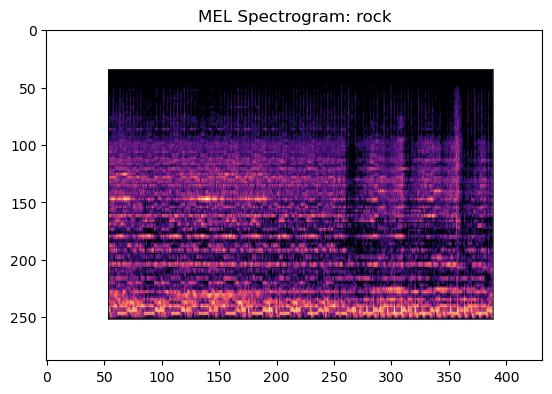

In [39]:
train_gen, valid_gen = get_train_and_validation_data(training_path=TRAIN_PATH,training_options=train_options)

train_gen_mapping = {}

#Train gen does weird shuffle we need to reverse the mapping
for key in train_gen.class_indices:
    train_gen_mapping[train_gen.class_indices[key]] = key

print(train_gen.class_indices)
print(train_gen_mapping)


images, labels = next(train_gen)


# Display first image
plt.imshow(images[0])
plt.title(f"MEL Spectrogram: {train_gen_mapping[labels[0].argmax()]}")  
plt.show()

Found 200 images belonging to 10 classes.


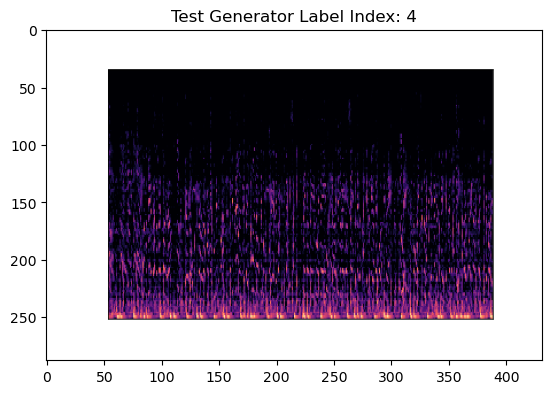

In [30]:
test_gen = get_test_data(test_path=TEST_PATH,testing_options= test_options)

images, labels = next(test_gen)

# Display first image
plt.imshow(images[0])
plt.title(f"Test Generator Label Index: {labels[0].argmax()}")  
plt.show()